In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
from scipy import sparse
import csv

sc.settings.verbosity = 1 

In [8]:
os.environ['PATH'] = os.path.dirname(sys.executable) + ":" + os.environ['PATH']

In [3]:
!pip install git+https://github.com/BioTuring-Notebooks/CellphoneDB.git@master
!pip install h5py anndata pandas --upgrade

  Cloning https://github.com/BioTuring-Notebooks/CellphoneDB.git (to revision master) to /tmp/pip-req-build-wl2eqk_s
  Running command git clone --filter=blob:none --quiet https://github.com/BioTuring-Notebooks/CellphoneDB.git /tmp/pip-req-build-wl2eqk_s
  Resolved https://github.com/BioTuring-Notebooks/CellphoneDB.git to commit 9ab48d8888f11259bb3030c8d149d7bc7cdaf6e1
  Preparing metadata (setup.py) ... done
  Using cached PyYAML-5.4.1-cp38-cp38-manylinux1_x86_64.whl (662 kB)
  Created wheel for CellPhoneDB: filename=CellPhoneDB-3.0.0a7-py3-none-any.whl size=12675289 sha256=9c87a4b91ed6325fb1596443c8c1224718777038ce846350427ef5a3f6b42393
  Stored in directory: /tmp/pip-ephem-wheel-cache-naj_wlnt/wheels/b4/3e/8b/bdc2f64bb3005740c2e19323a20e0cc00911a6f29a774125dd
Successfully built CellPhoneDB
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: CellPhoneDB
    Found exis

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.14 requires jupyter-client<=6.1.12, but you have jupyter-client 7.1.2 which is incompatible.
nbdev 1.1.14 requires nbconvert<6, but you have nbconvert 6.4.2 which is incompatible.
cellxgene 1.0.0 requires h5py>=3.0.0, but you have h5py 2.10.0 which is incompatible.


In [7]:
import urllib.request
ad_sc, _ = urllib.request.urlretrieve('https://www.dropbox.com/s/8wa2y53wav0mt87/prostate_ad_sc.h5ad?dl=1',
                                            "prostate_ad_sc.h5ad")
ad_sp, _ = urllib.request.urlretrieve('https://www.dropbox.com/s/mno44hzpz4mqunm/prostate_ad_sp.h5ad?dl=1',
                                            "prostate_ad_sp.h5ad")

In [22]:
adata = sc.read('prostate_ad_sc.h5ad')

In [10]:
adata.obs['cell type - subgroup (standardized)'].values.describe()

,counts,freqs
categories,,
Unassigned,2103,0.146540
basal cell,9203,0.641279
club cell,610,0.042506
fibroblast,594,0.041391
leukocyte,221,0.015400
luminal cell of prostate epithelium,1136,0.079158
neuroendocrine cell,9,0.000627
smooth muscle cell,475,0.033099


In [23]:
adata_sp = sc.read('prostate_ad_sp.h5ad')

In [12]:
adata_sp

AnnData object with n_obs × n_vars = 2543 × 16527
    obs: 'in_tissue', 'array_row', 'array_col', 'uniform_density', 'rna_count_based_density', 'basal cell', 'Unassigned', 'club cell', 'luminal cell of prostate epithelium', 'smooth muscle cell', 'fibroblast', 'leukocyte', 'neuroendocrine cell'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'sparsity'
    uns: 'overlap_genes', 'spatial', 'training_genes'
    obsm: 'spatial', 'tangram_ct_pred'

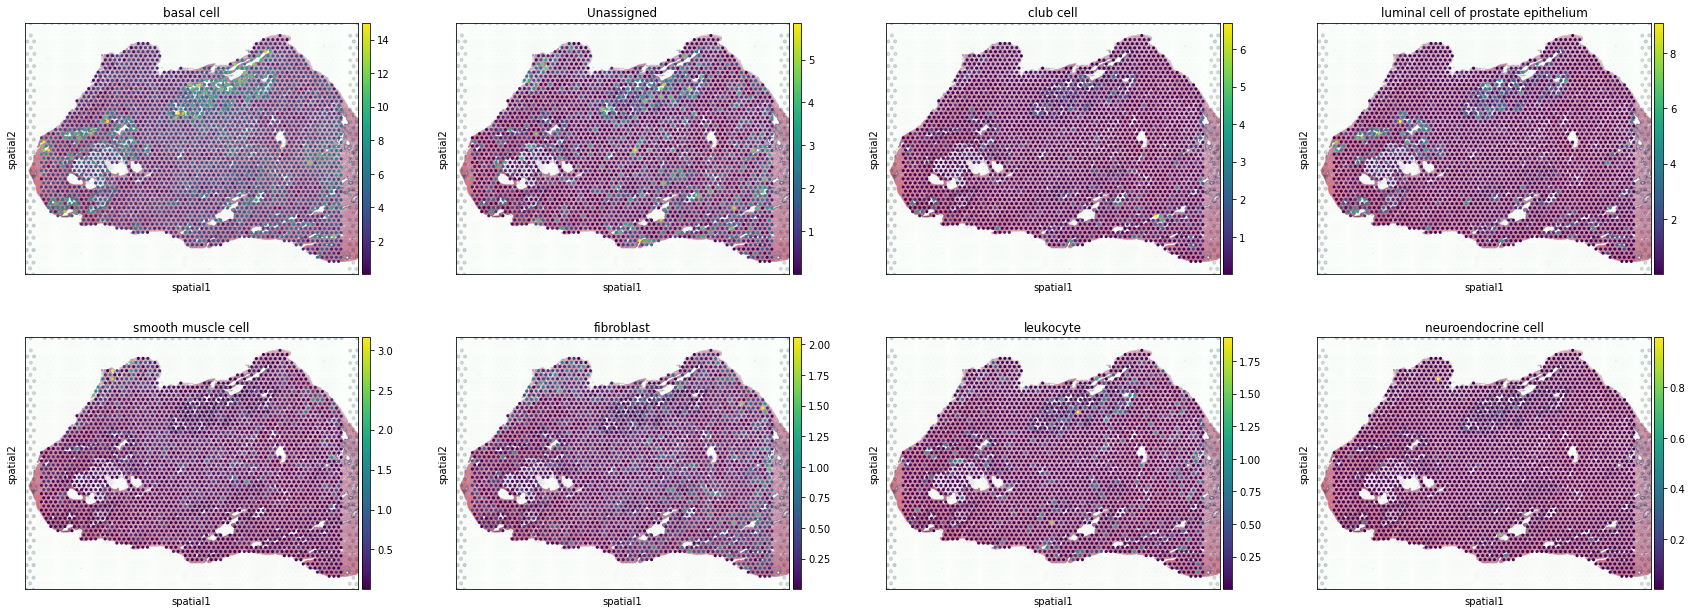

In [13]:
sc.pl.spatial(
    adata_sp,
    color= ["basal cell", "Unassigned", "club cell", "luminal cell of prostate epithelium", 
            "smooth muscle cell", "fibroblast", "leukocyte", "neuroendocrine cell"])

# 1. 准备microenv文件，两个column(cluster; microenvironment)

In [14]:
with open('prostate_microenvironment.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    tsv_writer.writerow(['cluster', 'microenvironment'])
    tsv_writer.writerow(['basal cell', 'tubular gland'])
    tsv_writer.writerow(['luminal cell of prostate epithelium', 'tubular gland'])

In [15]:
!head prostate_microenvironment.tsv

cluster	microenvironment
basal cell	tubular gland
luminal cell of prostate epithelium	tubular gland


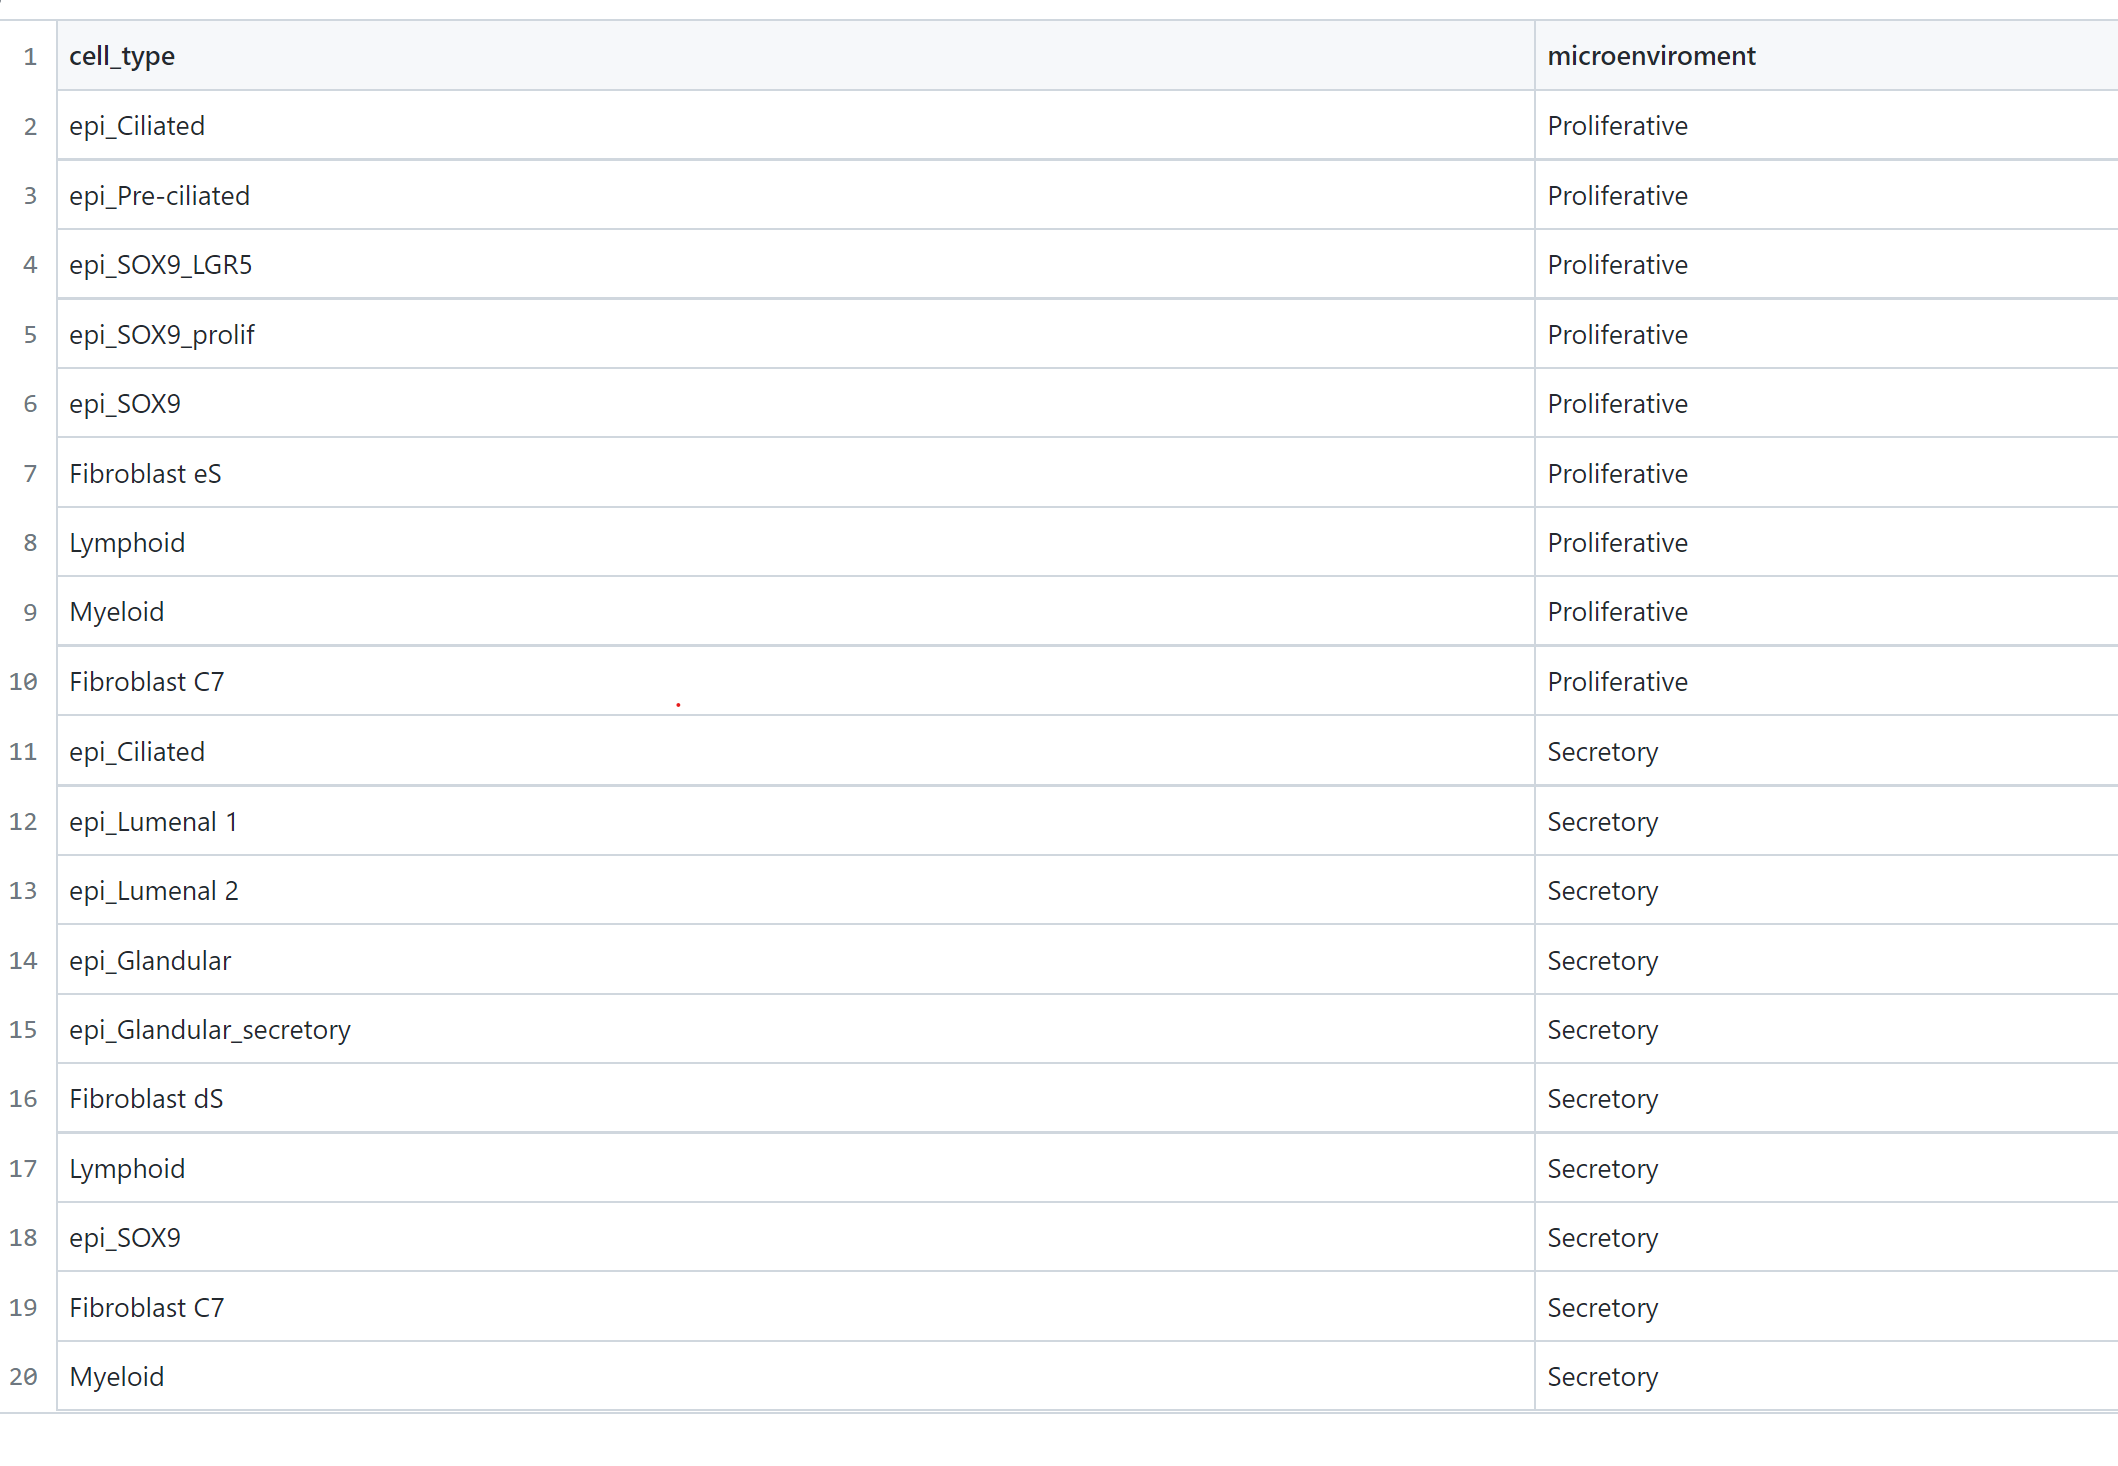

# 2. 准备single cell (不是spatio)的h5ad文件 /Convert Ens name to gene symbol （主要全部转成gene symbol大写）

In [ ]:
!wget -O gene_name_human.csv https://www.dropbox.com/s/kzwbcvpbwxfr7sg/gene_name_human.csv?dl=1

In [24]:
gene_df = pd.read_csv("gene_name_human.csv")

In [25]:
gene_df = gene_df[gene_df.primary==1]

In [26]:
gene_df

,gene_id,name,primary
0,ENSG00000079459,FDFT1,1
1,ENSG00000224586,GPX5,1
2,ENSG00000198788,MUC2,1
3,ENSG00000232995,RGS5,1
4,ENSG00000143248,RGS5,1
...,...,...,...
36546,ENSG00000116885,OSCP1,1
36547,ENSG00000201448,SNORA63C,1
36548,ENSG00000116898,MRPS15,1
36549,ENSG00000119535,CSF3R,1


In [27]:
adata.var_names

Index(['ensg00000121410', 'ensg00000268895', 'ensg00000148584',
       'ensg00000175899', 'ensg00000245105', 'ensg00000166535',
       'ensg00000128274', 'ensg00000094914', 'ensg00000081760',
       'ensg00000114771',
       ...
       'ctd-2060l22.1', 'hncat21', 'rp11-506f3.1', 'rp11-557n21.1',
       'kb-51a8.1', 'rp11-153f10.2', 'hrat92', 'rp11-722g7.1',
       'ensg00000235300', 'rp11-605b16.1'],
      dtype='object', length=22756)

In [28]:
ensgid = np.array(adata.var_names)
ensgid = [g.upper() for g in ensgid]
gene_df.index = gene_df["gene_id"]
gene_map = dict(zip(gene_df.gene_id.to_list(), gene_df.name.to_list()))
gene_symbol = [gene_map.get(g, g) for g in ensgid]
adata.var_names = gene_symbol

In [29]:
adata.var_names

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'AAAS',
       'AACS', 'AADAC',
       ...
       'CTD-2060L22.1', 'HNCAT21', 'RP11-506F3.1', 'RP11-557N21.1',
       'KB-51A8.1', 'RP11-153F10.2', 'HRAT92', 'RP11-722G7.1', 'THRA1/BTR',
       'RP11-605B16.1'],
      dtype='object', length=22756)

In [ ]:
adata.write_h5ad("ad_sc.cellphonedb.h5ad")

# 3. 准备差异表达基因文件

In [24]:
sc.pp.log1p(adata)

In [25]:
# find DEG
sc.tl.rank_genes_groups(adata, 'cell type - subgroup (standardized)', n_genes = 100)

In [26]:
marker_table = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
marker_table.head()

,Unassigned,basal cell,club cell,fibroblast,leukocyte,luminal cell of prostate epithelium,neuroendocrine cell,smooth muscle cell
0,TMSB4X,KRT5,WFDC2,DCN,SRGN,SERF2,TSTD1,IGFBP7
1,B2M,KRT15,SLPI,FBLN1,TYROBP,AZGP1,PFDN5,CALD1
2,NEAT1,DST,LCN2,LGALS1,VIM,KLK3,SPINT2,C11ORF96
3,EMP1,KRT17,ELF3,IGFBP7,B2M,TSPAN8,CD164,VIM
4,S100P,S100A2,RARRES1,C11ORF96,RGS1,MSMB,TMA7,LGALS1


转换成cellphoneDB格式

In [29]:
marker_table_melt = pd.melt(marker_table, value_vars=marker_table.keys(), value_name="gene", var_name="cluster")
marker_table_melt.head()

,cluster,gene
0,Unassigned,TMSB4X
1,Unassigned,B2M
2,Unassigned,NEAT1
3,Unassigned,EMP1
4,Unassigned,S100P


In [30]:
marker_table_melt.to_csv("deg_table.tsv", sep="\t", index=False)

# 4. 准备cell annotation文件（meta.csv）

In [31]:
df_meta = pd.DataFrame(data={'Cell':list(adata.obs.index),
                             'cluster':[ i for i in adata.obs['cell type - subgroup (standardized)']]
                            })
df_meta.set_index('Cell', inplace=True)

In [33]:
df_meta.head()

,cluster
Cell,
D27PrTz_TCTTCGGTCTAAGCCA,basal cell
D27PrTz_GGCTCGAGTGTGACCC,Unassigned
D35PrTz_TACACGACAAGCTGAG,basal cell
D27PrTz_CGAATGTTCTAACCGA,basal cell
D17PrTz_TGGTTAGGTAGCGTGA,club cell


In [34]:
df_meta.to_csv('prostate_meta.tsv', sep = '\t')

In [35]:
df_meta["cluster"].unique()

array(['basal cell', 'Unassigned', 'club cell',
       'luminal cell of prostate epithelium', 'smooth muscle cell',
       'fibroblast', 'leukocyte', 'neuroendocrine cell'], dtype=object)

# 运行 CellphoneDB v3

In [12]:
output_path = "prostate_cellphonedb"

In [13]:
!cellphonedb method degs_analysis \
    prostate_meta.tsv  \
    ad_sc.cellphonedb.h5ad \
    deg_table.tsv \
    --microenvs prostate_microenvironment.tsv \
    --counts-data hgnc_symbol  \
    --output-path {output_path} \
    --threshold 0.1 # min percent of expressed cells in each cluster

[ ][APP][02/06/22-16:23:10][WARNING] Latest local available version is `v2.0.0`, using it
[ ][APP][02/06/22-16:23:10][WARNING] User selected downloaded database `v2.0.0` is available, using it
[ ][CORE][02/06/22-16:23:10][INFO] Initializing SqlAlchemy CellPhoneDB Core
[ ][CORE][02/06/22-16:23:10][INFO] Using custom database at /home/sky1ove/.cpdb/releases/v2.0.0/cellphone.db
[ ][APP][02/06/22-16:23:10][INFO] Launching Method cpdb_degs_analysis_local_method_launcher
[ ][APP][02/06/22-16:23:10][INFO] Launching Method _set_paths
[ ][APP][02/06/22-16:23:10][INFO] Launching Method _load_meta_counts
[ ][APP][02/06/22-16:23:11][INFO] Launching Method _check_counts_data
[ ][APP][02/06/22-16:23:11][INFO] Launching Method _load_degs
[ ][APP][02/06/22-16:23:11][INFO] Launching Method _load_microenvs
[ ][CORE][02/06/22-16:23:11][INFO] Launching Method cpdb_degs_analysis_launcher
[ ][CORE][02/06/22-16:23:11][INFO] Launching Method _counts_validations
[ ][CORE][02/06/22-16:23:11][INFO] Launching Met

In [14]:
rev_int = pd.read_csv(f"{output_path}/relevant_interactions.txt", sep="\t")

In [15]:
rev_int.head()

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,basal cell|basal cell,luminal cell of prostate epithelium|basal cell,luminal cell of prostate epithelium|luminal cell of prostate epithelium
0,CPI-SC0E3784FFB,LAMC1_a2b1 complex,simple:P11047,complex:a2b1 complex,LAMC1,NaN,True,False,False,curated,True,1,1,0
1,CPI-SC0D9B795CC,CDH1_a2b1 complex,simple:P12830,complex:a2b1 complex,CDH1,NaN,False,False,False,curated,True,1,1,0
2,CPI-SS0BF9FA3F2,ERBB3_NRG1,simple:P21860,simple:Q02297,ERBB3,NRG1,True,True,True,curated,False,0,1,0
3,CPI-SS0C10824C7,EGFR_HBEGF,simple:P00533,simple:Q99075,EGFR,HBEGF,True,True,True,curated,False,1,1,0
4,CPI-SS0632A027A,CD44_HBEGF,simple:P16070,simple:Q99075,CD44,HBEGF,True,True,True,"I2D,InnateDB-All",False,1,1,0


In [16]:
means = pd.read_csv(f"{output_path}/significant_means.txt", sep="\t")
means.set_index("interacting_pair", inplace=True)
means.head()

,id_cp_interaction,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,rank,basal cell|basal cell,basal cell|luminal cell of prostate epithelium,luminal cell of prostate epithelium|basal cell,luminal cell of prostate epithelium|luminal cell of prostate epithelium
interacting_pair,,,,,,,,,,,,,,,
CD46_JAG1,CPI-SS01A07768A,simple:P15529,simple:P78504,CD46,JAG1,False,True,False,curated,False,0.25,NaN,NaN,0.204,NaN
ERBB3_NRG1,CPI-SS0BF9FA3F2,simple:P21860,simple:Q02297,ERBB3,NRG1,True,True,True,curated,False,0.25,NaN,NaN,0.169,NaN
CD44_HBEGF,CPI-SS0632A027A,simple:P16070,simple:Q99075,CD44,HBEGF,True,True,True,"I2D,InnateDB-All",False,0.50,0.423,NaN,0.434,NaN
EGFR_HBEGF,CPI-SS0C10824C7,simple:P00533,simple:Q99075,EGFR,HBEGF,True,True,True,curated,False,0.50,0.290,NaN,0.267,NaN
DSC2_DSG2,CPI-SS06D13FCD3,simple:Q02487,simple:Q14126,DSC2,DSG2,False,False,False,curated,False,0.50,NaN,NaN,0.246,0.295


In [17]:
int_matrix = means[["basal cell|basal cell", "luminal cell of prostate epithelium|basal cell", 
                      "luminal cell of prostate epithelium|luminal cell of prostate epithelium"]]
int_matrix

,basal cell|basal cell,luminal cell of prostate epithelium|basal cell,luminal cell of prostate epithelium|luminal cell of prostate epithelium
interacting_pair,,,
CD46_JAG1,NaN,0.204,NaN
ERBB3_NRG1,NaN,0.169,NaN
CD44_HBEGF,0.423,0.434,NaN
EGFR_HBEGF,0.290,0.267,NaN
DSC2_DSG2,NaN,0.246,0.295
...,...,...,...
BMR1A_AVR2B_BMP2,NaN,NaN,NaN
BMR1A_ACR2A_BMP2,NaN,NaN,NaN
BMPR1B_BMPR2_BMP2,NaN,NaN,NaN


In [18]:
pair = "luminal cell of prostate epithelium|basal cell"
res = int_matrix[[pair]]
res.sort_values(by=pair, ascending=False)

,luminal cell of prostate epithelium|basal cell
interacting_pair,
CD44_HBEGF,0.434
CDH1_a2b1 complex,0.381
EGFR_HBEGF,0.267
LAMC1_a2b1 complex,0.255
DSC2_DSG2,0.246
...,...
BMR1A_AVR2B_BMP2,NaN
BMR1A_ACR2A_BMP2,NaN
BMPR1B_BMPR2_BMP2,NaN


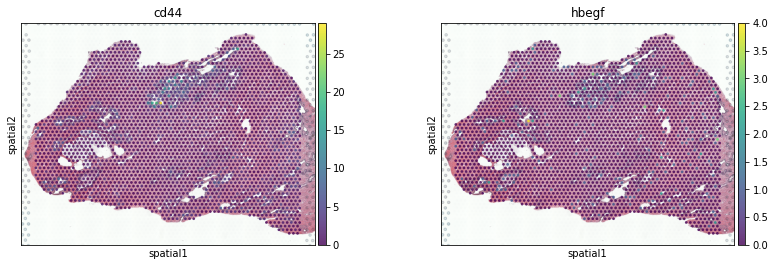

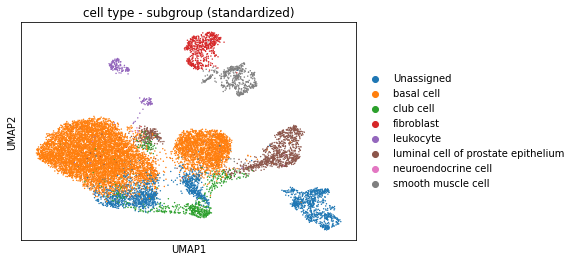

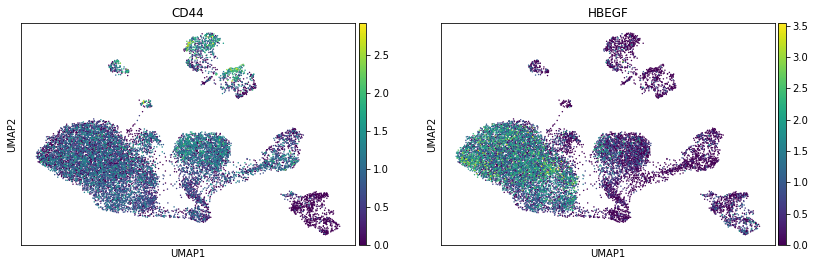

In [35]:
sc.pl.spatial(adata_sp, img_key="hires", color=["cd44", "hbegf"], alpha=0.8)
sc.pl.umap(adata, color=['cell type - subgroup (standardized)'])
sc.pl.umap(adata, color=[ 'CD44', 'HBEGF'])

In [20]:
res.head(20)

,luminal cell of prostate epithelium|basal cell
interacting_pair,
CD46_JAG1,0.204
ERBB3_NRG1,0.169
CD44_HBEGF,0.434
EGFR_HBEGF,0.267
DSC2_DSG2,0.246
LAMC1_a2b1 complex,0.255
CDH1_a2b1 complex,0.381
EFNA1_EPHA2,0.225
FGFR2_FGF23,NaN


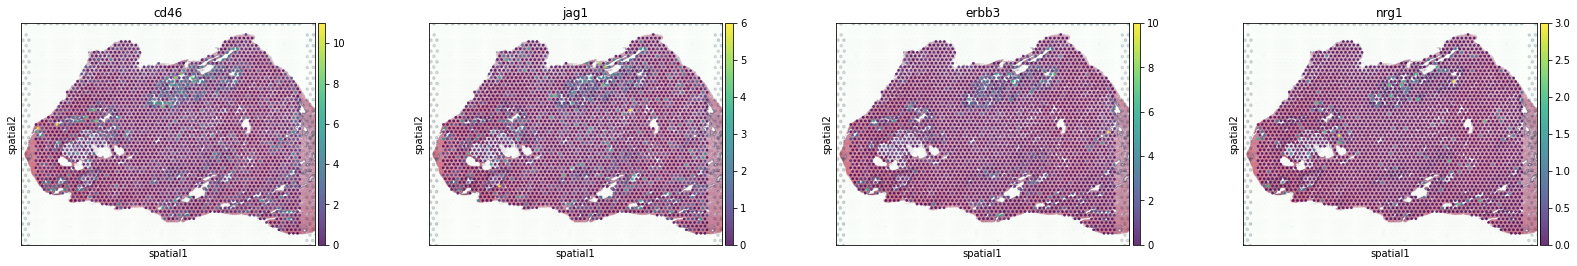

In [30]:
sc.pl.spatial(adata_sp, img_key="hires", color=["cd46","jag1", "erbb3", "nrg1"], alpha=0.8)

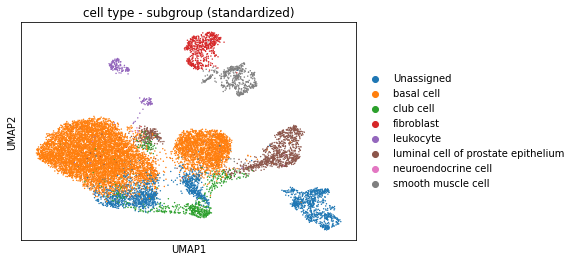

In [31]:
sc.pl.umap(adata, color=['cell type - subgroup (standardized)'])
sc.pl.umap(adata, color=[ 'CD46', 'JAG1', 'ERBB3', 'NRG1'])

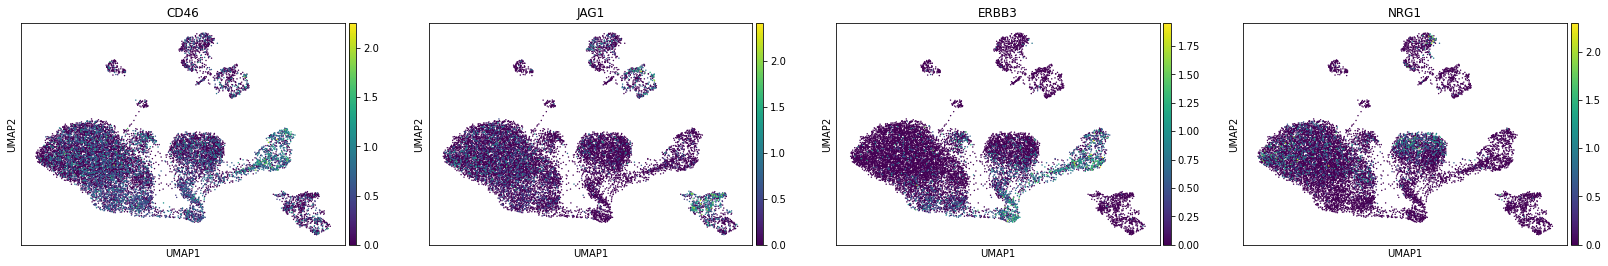

In [32]:
sc.pl.umap(adata, color=[ 'CD46', 'JAG1', 'ERBB3', 'NRG1'])